In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

%config InlineBackend.figure_format = 'svg'

In [2]:
init_df = pd.read_csv('../../datasets/tokenized/blog_authorship_tokenized.csv', usecols=['text', 'tokenized', 'n_words', 'gender'])
init_df.sample(5)

,text,gender,n_words,tokenized
460341,"Okay, so to start things off, I figured I woul...",male,299,"okay , so to start things off , i figured i wo..."
120858,"Sunday night was exceptionally clear, so we sp...",male,79,"sunday night was exceptionally clear , so we s..."
519858,I am going to my first Sarah Wesley rehearsal ...,male,24,i am going to my first sarah wesley rehearsal ...
290363,"Mr. khadeer babu, darga mitta kathalu. polera...",male,55,"mr. khadeer babu , darga mitta kathalu . pol..."
46995,A one minute blog post. This life is a good li...,male,138,a one minute blog post . this life is a good l...


In [3]:
init_df.isnull().sum()

text         0
gender       0
n_words      0
tokenized    0
dtype: int64

In [4]:
# Stratify the sample by gender
df = init_df.groupby('gender', group_keys=False).apply(lambda x: x.sample(frac=.015))
df.shape

(9534, 4)

In [5]:
df['gender'].value_counts()

male      4835
female    4699
Name: gender, dtype: int64

In [6]:
enc = LabelEncoder()
enc.fit(df['gender'])
encoded_labels = dict(zip(enc.classes_, enc.transform(enc.classes_))) # will use that in the cm later
df['gender'] = enc.transform(df['gender'])
encoded_labels

{'female': 0, 'male': 1}

## On tokenized data &ndash; vectorizer-only

In [7]:
X = df[['tokenized']]
y = df['gender']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=True, random_state=97, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7627, 1), (1907, 1), (7627,), (1907,))

In [8]:
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [9]:
word_23_tf = TfidfVectorizer(analyzer='word', ngram_range=(2, 3), max_features=5000, stop_words=None)
char_23_tf = TfidfVectorizer(analyzer='char', ngram_range=(2, 3), max_features=5000, stop_words=None)

word_pipe = Pipeline([
    ('selector', ItemSelector(key='tokenized')),
    ('vectorizer', word_23_tf)
])

char_pipe = Pipeline([
    ('selector', ItemSelector(key='tokenized')),
    ('vectorizer', char_23_tf)
])

pipe = Pipeline([
    (
        'feats',
        FeatureUnion([  
            ('word_pipeline', word_pipe),
            ('char_pipeline', char_pipe)
        ]),
    ),
    ('clf', SVC(random_state=42))
])

In [10]:
param_grid = {
    'clf__kernel': ['linear', 'rbf']
}

In [11]:
gs = GridSearchCV(pipe, param_grid, cv=10, scoring='f1_macro', n_jobs=-1, refit=True, verbose=10, error_score='raise')

gs.fit(X_train, y_train)
print(gs.best_params_)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
{'clf__kernel': 'rbf'}


In [12]:
y_pred = gs.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.60      0.62       940
           1       0.63      0.67      0.65       967

    accuracy                           0.64      1907
   macro avg       0.64      0.64      0.64      1907
weighted avg       0.64      0.64      0.64      1907



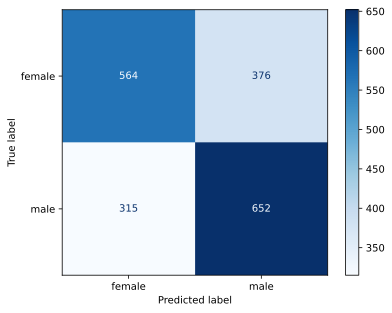

In [14]:
cm = confusion_matrix(y_test, y_pred, labels=gs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs.classes_)
disp.display_labels = encoded_labels
disp.plot(cmap='Blues');